In [1]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def format_csv(path : str):
    dataset_input  = pd.read_csv(path)
    domains_unique = dataset_input['domain'].unique()
    output_dict = {'timestamp':list()}
    for domain in domains_unique: output_dict[domain]=list()
    for timestamp in dataset_input['timestamp'].unique():
        x = dataset_input.loc[dataset_input['timestamp'] == timestamp]
        output_dict['timestamp'].append(timestamp)
        for domain in domains_unique: 
            serie = x.loc[x['domain'] == domain]['measure']
            output_dict[domain].append(serie.iloc[0]) if len(serie)>0 else output_dict[domain].append(np.nan)
    output_df = pd.DataFrame(output_dict)
    for key in output_df.keys():
        if key not in ['timestamp', 'phase']: output_df[key] = pd.to_numeric(output_df[key], errors='coerce', downcast="float")
    return output_df

def merge_datasets(input_datasets : dict):
    for name, dataset in input_datasets.items(): dataset['dataset'] = name
    return pd.concat(input_datasets.values())

## Training

In [5]:
#dataset_def  = format_csv('/home/pierre/src/cinergy-models/consumption-training.csv')
dataset_training = format_csv('/home/pierre/src/cinergy-models/models/nova-10.lyon.grid5000.fr-training.csv')

In [37]:
zoom = dataset_training.loc[dataset_training['timestamp'] < 120]

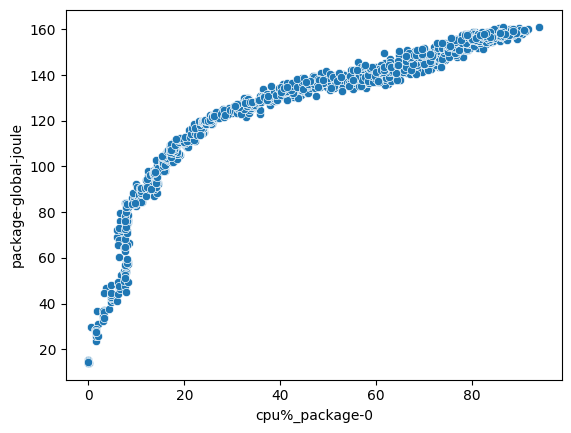

In [7]:
#g = sns.scatterplot(data=dataset_training, x='timestamp', y='cpu%_package-0')
g = sns.scatterplot(data=dataset_training, x='cpu%_package-0', y='package-global-joule')

#### Quelques réflexions
Est-ce que la granularité de la VM est la bonne pour nos investigations? Faire le model d'un vCPU/process à multiplier par le nombre de vcpu semble plus simple. Ici: idle: 15 joules (oui mais n'est probablement pas à distribuer) et palier de 25% à 25-30 (+10-15) joules

## Groundtruth

In [54]:
dataset_gt = format_csv('/home/pierre/src/cinergy-models/models/nova-10.lyon.grid5000.fr-groundtruth.csv')

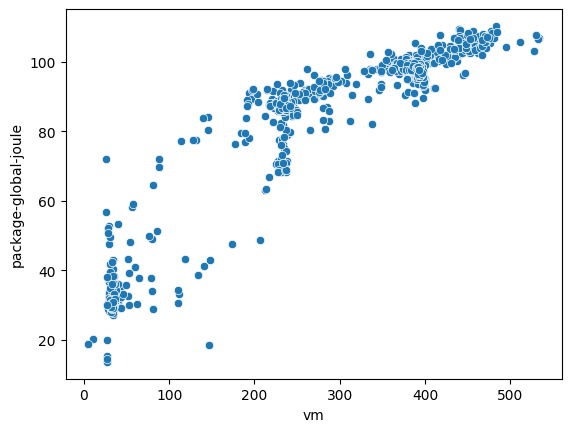

In [32]:
dataset_gt = sns.scatterplot(data=dataset_gt, x='vm', y='package-global-joule')

## Cloudlike

In [57]:
dataset_cl = format_csv('/home/pierre/src/cinergy-models/models/nova-10.lyon.grid5000.fr-cloudlike.csv')

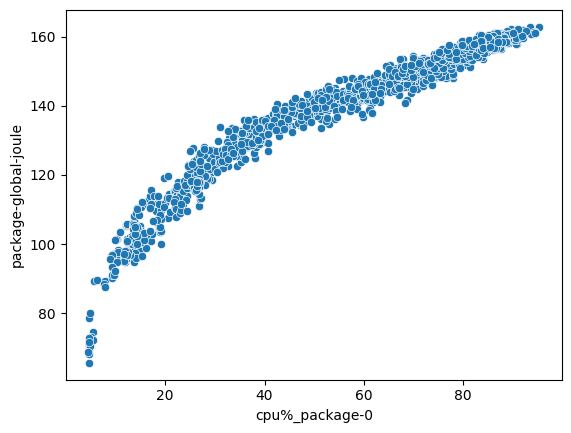

In [31]:
g = sns.scatterplot(data=dataset_cl, x='cpu%_package-0', y='package-global-joule')

## Training model

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

In [52]:
x = dataset_training['cpu%_package-0'].dropna()
y = dataset_training['package-global-joule'].dropna()

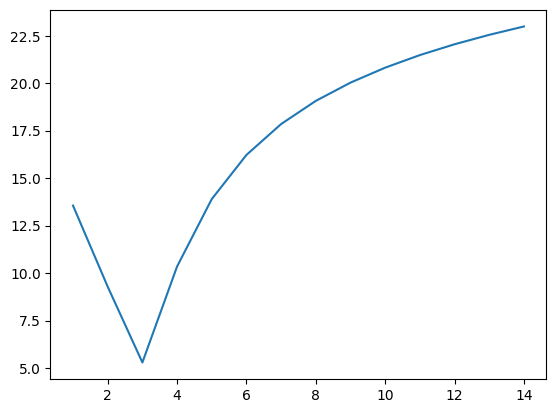

Best degree 3


In [49]:
def degree_choice(x,y, degree):
    polynomial_features= PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(pd.DataFrame(x))

    model = LinearRegression()
    model.fit(x_poly, y)
    y_predict = model.predict(x_poly)

    return root_mean_squared_error(y,y_predict)

degree_list=range(1,15)
rmse_list=list()
for degree in degree_list:
    rmse_list.append(degree_choice(x,y,degree))

plt.plot(degree_list, rmse_list)
plt.show()

best_degree = degree_list[min(range(len(rmse_list)), key=rmse_list.__getitem__)]
print('Best degree', best_degree)

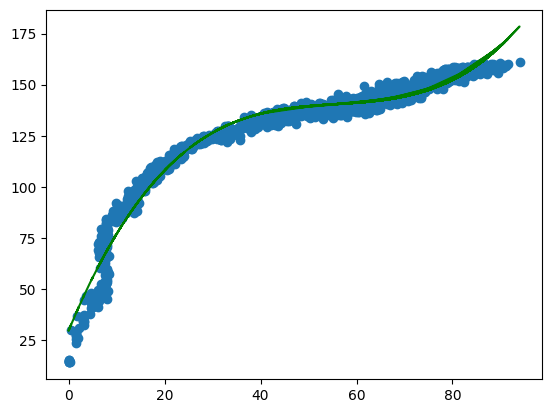

r2_score /1 0.9687470197677612
root mean squared error 5.290241
mean absolut error 3.9725585


In [89]:
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(pd.DataFrame(x))

model = LinearRegression()
reg = model.fit(x_poly, y)
y_predict = model.predict(x_poly)

plt.scatter(x, y)
plt.plot(x, y_predict, color='g')
plt.show()

print('r2_score /1', r2_score(y,y_predict))
print('root mean squared error', root_mean_squared_error(y,y_predict))
print('mean absolut error', mean_absolute_error(y, y_predict))

In [191]:
model_as_coeff = (reg.intercept_, reg.coef_)
b = reg.intercept_
formula = str(b)
for i in range(len(reg.coef_)):
    formula+= ' + ' + str(reg.coef_[i]) + '*(x**' + str(i) + ')'
print('f(x) =', formula)

def estimate(model : tuple, x : int, include_static : bool = True):
    (b, coeff )= model
    res = b if include_static else 0
    for degree in range(len(coeff)):
        res+= coeff[degree]*(x**degree)
    return res

f(x) = 29.821106 + 0.0*(x**0) + 5.6463175*(x**1) + -0.09837355*(x**2) + 0.0005865097*(x**3)


## Now that we have a model, we test it against our data (cloud-like vs groundtruth)

In [176]:
# Groundtruth
core_host = 32
groundtruth = dataset_gt.dropna()
groundtruth = groundtruth.assign(host_percent_vm = groundtruth.vm / core_host)

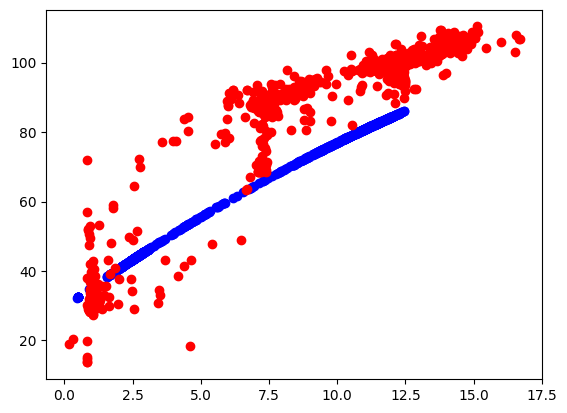

In [181]:
# Prediction from cloud-like dataset
cloudlike  = dataset_cl.dropna()
cloudlike = cloudlike.assign(host_percent_vm = cloudlike.vm / core_host)
cloudlike = cloudlike.assign(prediction = estimate(model_as_coeff, cloudlike.host_percent_vm))

plt.scatter(cloudlike['host_percent_vm'], cloudlike['prediction'], color='b', label='prediction')
plt.scatter(groundtruth['host_percent_vm'], groundtruth['package-global-watt'], color='r', label='groundtruth')
plt.show()

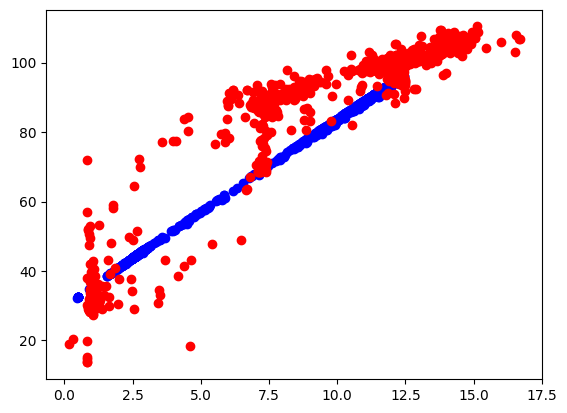

In [189]:
# Prediction from cloud-like dataset
cloudlike  = dataset_cl.dropna()
cloudlike = cloudlike.assign(host_percent_vm = cloudlike.vm / core_host)
cloudlike = cloudlike.assign(prediction = estimate(model_as_coeff, cloudlike.CPU0/core_host) + estimate(model_as_coeff, cloudlike.CPU1/core_host) + estimate(model_as_coeff, cloudlike.CPU2/core_host) + estimate(model_as_coeff, cloudlike.CPU3/core_host))

plt.scatter(cloudlike['host_percent_vm'], cloudlike['prediction'], color='b', label='prediction')
plt.scatter(groundtruth['host_percent_vm'], groundtruth['package-global-joule'], color='r', label='groundtruth')
plt.show()